<a href="https://colab.research.google.com/github/ghalazz/Spotify_data_analysis/blob/main/SQL_retail__database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Database Download**





In [1]:
import os, urllib.request

# Create a folder to keep data files
os.makedirs("data", exist_ok=True)

# Public GitHub URL to the SQLite file
url = "https://raw.githubusercontent.com/jpwhite3/northwind-SQLite3/main/dist/northwind.db"

# Download to /data as northwind.sqlite
urllib.request.urlretrieve(url, "data/northwind.sqlite")
print("Downloaded to data/northwind.sqlite")

Downloaded to data/northwind.sqlite


In [2]:
import os
size_mb = os.path.getsize("data/northwind.sqlite") / (1024*1024)
print(f"File exists. Size ≈ {size_mb:.2f} MB")

File exists. Size ≈ 23.56 MB


**Connecting to the database**

In [3]:
import sqlite3, pandas as pd

conn = sqlite3.connect("data/northwind.sqlite")
print("Connected")

Connected


**Exploring the tables**

In [4]:
pd.read_sql_query(
 """SELECT name
    FROM sqlite_master
    WHERE type='table'
    ORDER BY name;""",
    conn
)

,name
0,Categories
1,CustomerCustomerDemo
2,CustomerDemographics
3,Customers
4,EmployeeTerritories
5,Employees
6,Order Details
7,Orders
8,Products
9,Regions


**Business Queriest**

---

*Different SQL queries to analyze the Northwind database.*

In [5]:
for t in ["Customers", "Orders", "OrderDetails", "Products", "Categories"]:
    print(f"\n-- {t} --")
    display(pd.read_sql_query(f"PRAGMA table_info({t});", conn))


-- Customers --


,cid,name,type,notnull,dflt_value,pk
0,0,CustomerID,TEXT,0,None,1
1,1,CompanyName,TEXT,0,None,0
2,2,ContactName,TEXT,0,None,0
3,3,ContactTitle,TEXT,0,None,0
4,4,Address,TEXT,0,None,0
5,5,City,TEXT,0,None,0
6,6,Region,TEXT,0,None,0
7,7,PostalCode,TEXT,0,None,0
8,8,Country,TEXT,0,None,0
9,9,Phone,TEXT,0,None,0



-- Orders --


,cid,name,type,notnull,dflt_value,pk
0,0,OrderID,INTEGER,1,None,1
1,1,CustomerID,TEXT,0,None,0
2,2,EmployeeID,INTEGER,0,None,0
3,3,OrderDate,DATETIME,0,None,0
4,4,RequiredDate,DATETIME,0,None,0
5,5,ShippedDate,DATETIME,0,None,0
6,6,ShipVia,INTEGER,0,None,0
7,7,Freight,NUMERIC,0,0,0
8,8,ShipName,TEXT,0,None,0
9,9,ShipAddress,TEXT,0,None,0



-- OrderDetails --


,cid,name,type,notnull,dflt_value,pk



-- Products --


,cid,name,type,notnull,dflt_value,pk
0,0,ProductID,INTEGER,1,None,1
1,1,ProductName,TEXT,1,None,0
2,2,SupplierID,INTEGER,0,None,0
3,3,CategoryID,INTEGER,0,None,0
4,4,QuantityPerUnit,TEXT,0,None,0
5,5,UnitPrice,NUMERIC,0,0,0
6,6,UnitsInStock,INTEGER,0,0,0
7,7,UnitsOnOrder,INTEGER,0,0,0
8,8,ReorderLevel,INTEGER,0,0,0
9,9,Discontinued,TEXT,1,'0',0



-- Categories --


,cid,name,type,notnull,dflt_value,pk
0,0,CategoryID,INTEGER,0,None,1
1,1,CategoryName,TEXT,0,None,0
2,2,Description,TEXT,0,None,0
3,3,Picture,BLOB,0,None,0


In [6]:
def peek(table, n=5):
    return pd.read_sql_query(f'SELECT * FROM "{table}" LIMIT {n};', conn)

peek("Customers")
peek("Orders")
peek("Order Details")
peek("Products")

,ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


** Q1 – Customers by country (top 10)**

In [7]:
q1 = """
SELECT Country, COUNT(*) AS customers
FROM Customers
GROUP BY Country
ORDER BY customers DESC, Country
LIMIT 10;
"""
df_q1 = pd.read_sql_query(q1, conn)
df_q1

,Country,customers
0,USA,13
1,France,11
2,Germany,11
3,Brazil,9
4,UK,7
5,Mexico,5
6,Spain,5
7,Venezuela,4
8,Argentina,3
9,Canada,3


Text(0.5, 1.0, 'Top 10 Countries by Customer Count')

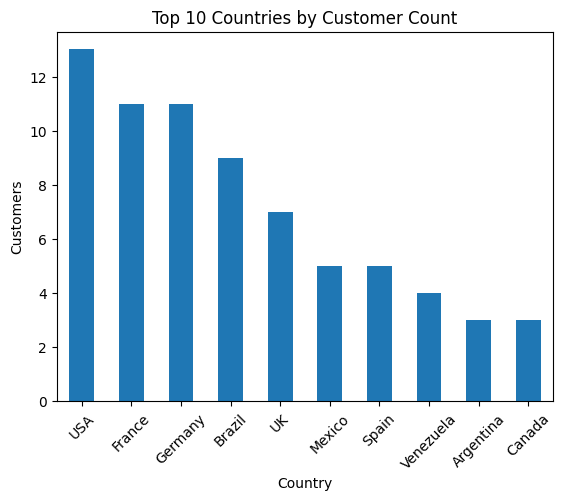

In [8]:
ax = df_q1.plot(kind="bar", x="Country", y="customers", legend=False, rot=45)
ax.set_xlabel("Country")
ax.set_ylabel("Customers")
ax.set_title("Top 10 Countries by Customer Count")

In [9]:
q_sales = """
SELECT
  c.Country,
  ROUND(SUM(od.UnitPrice * od.Quantity * (1.0 - od.Discount)), 2) AS Sales
FROM "Order Details" od
JOIN Orders o       ON o.OrderID = od.OrderID
JOIN Customers c    ON c.CustomerID = o.CustomerID
GROUP BY c.Country
ORDER BY Sales DESC, c.Country
LIMIT 10;
"""
df_sales = pd.read_sql_query(q_sales, conn)
df_sales

,Country,Sales
0,USA,62601564.84
1,France,53323305.76
2,Germany,51195766.82
3,Brazil,45801779.28
4,UK,33959254.80
5,Mexico,24802282.44
6,Spain,24023498.25
7,Venezuela,19424911.97
8,Argentina,14233566.76
9,Canada,14201667.46


In [10]:
q_density = """
SELECT
  c.Country,
  COUNT(DISTINCT o.OrderID) * 1.0 / COUNT(DISTINCT c.CustomerID) AS OrdersPerCustomer
FROM Customers c
LEFT JOIN Orders o ON o.CustomerID = c.CustomerID
GROUP BY c.Country
ORDER BY OrdersPerCustomer DESC, c.Country;
"""
pd.read_sql_query(q_density, conn)

,Country,OrdersPerCustomer
0,Brazil,184.333333
1,Austria,182.000000
2,Ireland,182.000000
3,Venezuela,181.500000
4,Mexico,179.600000
5,Switzerland,179.000000
6,Portugal,177.500000
7,Poland,177.000000
8,Sweden,176.500000
9,UK,176.285714


**Q2 – Monthly revenue**

In [11]:
q2 = """
WITH order_lines AS (
  SELECT
    od.OrderID,
    od.UnitPrice * od.Quantity * (1.0 - od.Discount) AS line_revenue
  FROM "Order Details" od
),
orders_by_date AS (
  SELECT
    o.OrderID,
    date(substr(o.OrderDate, 1, 10)) AS order_date
  FROM Orders o
)
SELECT
  strftime('%Y-%m', order_date) AS ym,
  ROUND(SUM(line_revenue), 2)   AS revenue
FROM orders_by_date
JOIN order_lines USING (OrderID)
GROUP BY ym
ORDER BY ym;
"""
df_q2 = pd.read_sql_query(q2, conn)
df_q2

,ym,revenue
0,2012-07,2066219.40
1,2012-08,3556875.79
2,2012-09,3440144.98
3,2012-10,3201529.96
4,2012-11,2980494.74
...,...,...
131,2023-06,3071787.73
132,2023-07,3350337.36
133,2023-08,3293158.67
134,2023-09,3544698.51


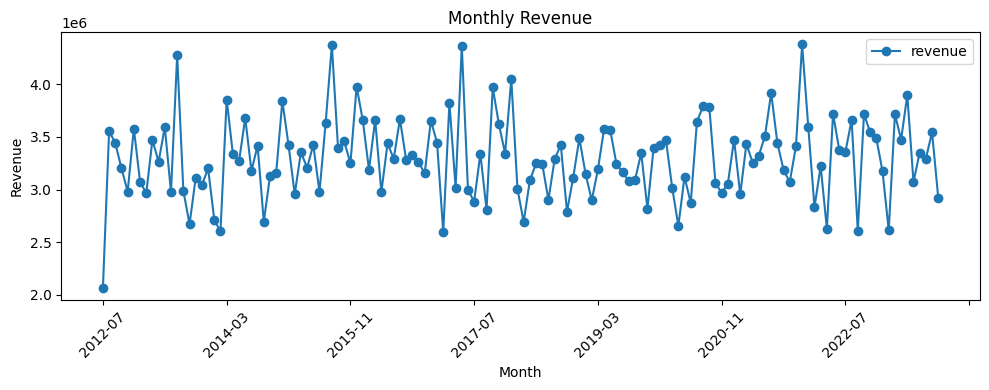

In [12]:
import matplotlib.pyplot as plt

df_q2.plot(x="ym", y="revenue", kind="line", marker="o", figsize=(10,4))
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Q3 – Top 5 product categories by revenue**

In [13]:
q3 = """
WITH order_lines AS (
  SELECT
    od.OrderID,
    od.ProductID,
    od.UnitPrice * od.Quantity * (1.0 - od.Discount) AS line_revenue
  FROM "Order Details" od
)
SELECT
  c.CategoryName,
  ROUND(SUM(ol.line_revenue), 2) AS revenue
FROM order_lines ol
JOIN Products p   ON p.ProductID  = ol.ProductID
JOIN Categories c ON c.CategoryID = p.CategoryID
GROUP BY c.CategoryName
ORDER BY revenue DESC
LIMIT 5;
"""
df_q3 = pd.read_sql_query(q3, conn)
df_q3

,CategoryName,revenue
0,Beverages,92163184.18
1,Confections,66337803.07
2,Meat/Poultry,64881147.97
3,Dairy Products,58018116.79
4,Condiments,55795126.78


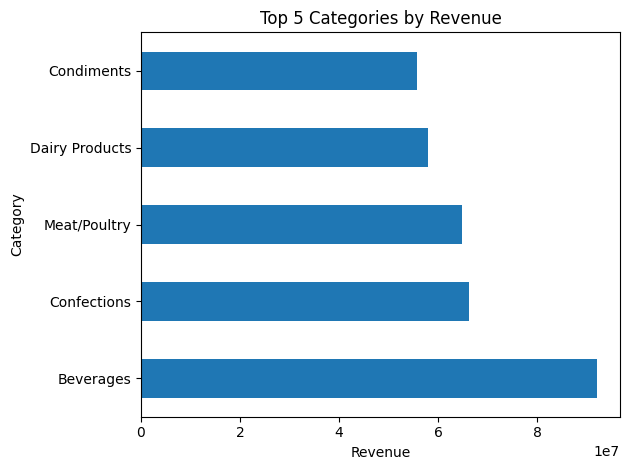

In [14]:
import matplotlib.pyplot as plt
ax = df_q3.plot(kind="barh", x="CategoryName", y="revenue", legend=False)
ax.set_xlabel("Revenue")
ax.set_ylabel("Category")
ax.set_title("Top 5 Categories by Revenue")
plt.tight_layout()

In [15]:
total = df_q3["revenue"].sum()
df_q3["share_%"] = (df_q3["revenue"] / total * 100).round(2)
df_q3

,CategoryName,revenue,share_%
0,Beverages,92163184.18,27.33
1,Confections,66337803.07,19.67
2,Meat/Poultry,64881147.97,19.24
3,Dairy Products,58018116.79,17.21
4,Condiments,55795126.78,16.55


**Q4 – Top 10 customers by total spend**

In [17]:
q4_top_customers = """
WITH order_lines AS (
  SELECT
    od.OrderID,
    od.UnitPrice * od.Quantity * (1.0 - od.Discount) AS line_revenue
  FROM "Order Details" od
)
SELECT
  c.CompanyName,
  ROUND(SUM(ol.line_revenue), 2) AS total_spend
FROM Orders o
JOIN order_lines ol ON ol.OrderID = o.OrderID
JOIN Customers c    ON c.CustomerID = o.CustomerID
GROUP BY c.CompanyName
ORDER BY total_spend DESC
LIMIT 10;
"""
df_q4 = pd.read_sql_query(q4_top_customers, conn)
df_q4

,CompanyName,total_spend
0,IT,9745371.29
1,B's Beverages,6154115.34
2,Hungry Coyote Import Store,5698023.67
3,Rancho grande,5559110.08
4,Gourmet Lanchonetes,5552309.81
5,Ana Trujillo Emparedados y helados,5534356.65
6,Ricardo Adocicados,5524517.31
7,Folies gourmandes,5505502.85
8,Let's Stop N Shop,5462198.02
9,LILA-Supermercado,5437438.34


Text(0.5, 1.0, 'Top 10 Customers by Total Spend')

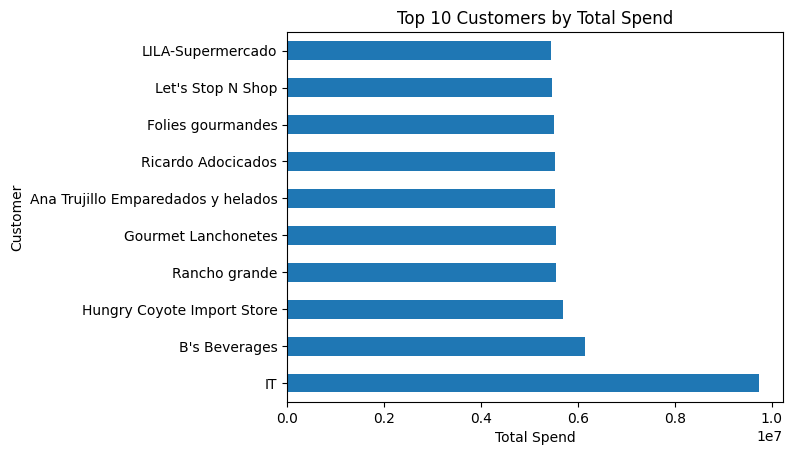

In [19]:
ax = df_q4.plot(kind="barh", x="CompanyName", y="total_spend", legend=False)
ax.set_xlabel("Total Spend")
ax.set_ylabel("Customer")
ax.set_title("Top 10 Customers by Total Spend")

**Q5 – Win‑back customers (no orders in last 90 days)**

In [22]:
q5_winback = """
WITH last_order AS (
  SELECT
    o.CustomerID,
    MAX(date(substr(o.OrderDate,1,10))) AS last_order_date
  FROM Orders o
  GROUP BY o.CustomerID
),
max_date AS (
  SELECT MAX(date(substr(OrderDate,1,10))) AS max_d FROM Orders
)
SELECT
  c.CompanyName,
  l.last_order_date
FROM last_order l
JOIN Customers c ON c.CustomerID = l.CustomerID
JOIN max_date m
WHERE julianday(m.max_d) - julianday(l.last_order_date) > 90
ORDER BY l.last_order_date;
"""
df_q5 = pd.read_sql_query(q5_winback, conn)
df_q5

,CompanyName,last_order_date
0,FISSA Fabrica Inter. Salchichas S.A.,2023-05-11
1,QUICK-Stop,2023-06-22
2,Mère Paillarde,2023-07-09
3,The Big Cheese,2023-07-16
4,Pericles Comidas clásicas,2023-07-27


In [28]:
q5_winback = """ WITH last_order AS (
  SELECT
    o.CustomerID,
    DATE(MAX(substr(o.OrderDate,1,10))) AS last_order_date
  FROM Orders o
  GROUP BY o.CustomerID
),
max_date AS (
  SELECT DATE(MAX(substr(OrderDate,1,10))) AS max_d FROM Orders
)
SELECT
  c.CompanyName,
  c.Country,
  l.last_order_date,
  CAST(julianday(m.max_d) - julianday(l.last_order_date) AS INT) AS days_since_last_order
FROM last_order l
JOIN Customers c ON c.CustomerID = l.CustomerID
JOIN max_date m
WHERE julianday(m.max_d) - julianday(l.last_order_date) > :cutoff_days
ORDER BY days_since_last_order DESC;
"""
df_q5 = pd.read_sql_query(q5_winback, conn, params={"cutoff_days": 90})

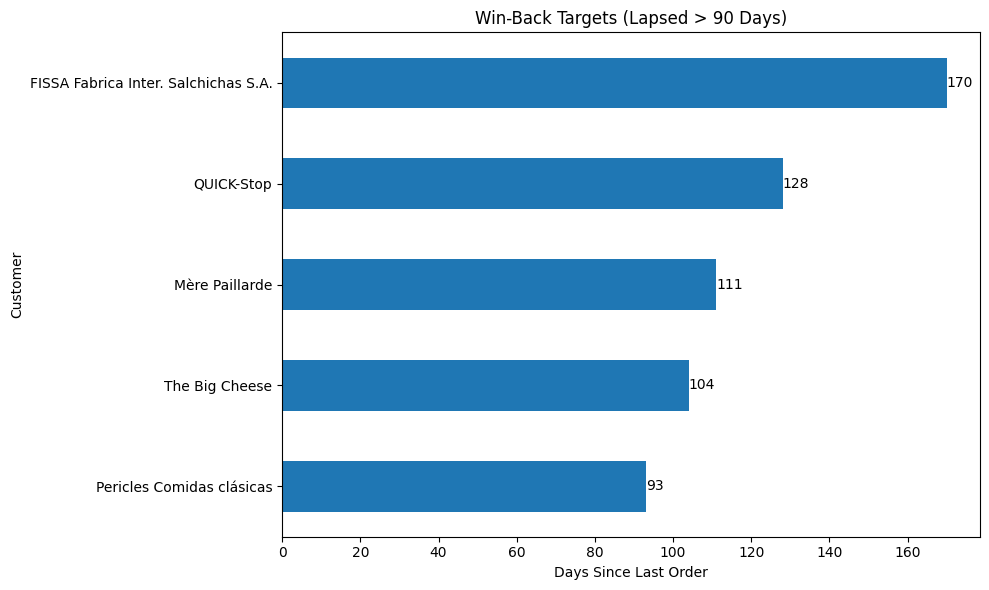

In [29]:
import matplotlib.pyplot as plt

ax = df_q5.plot(
    kind="barh",
    x="CompanyName",
    y="days_since_last_order",
    legend=False,
    figsize=(10,6)
)
ax.set_xlabel("Days Since Last Order")
ax.set_ylabel("Customer")
ax.set_title("Win-Back Targets (Lapsed > 90 Days)")
ax.invert_yaxis()
for c in ax.containers:
    ax.bar_label(c, fmt="%d", label_type="edge")
plt.tight_layout()
plt.show()

In [30]:
import os
os.makedirs("outputs", exist_ok=True)

# Rename these if your variables have different names
dfs_to_save = {
    "q2_monthly_revenue.csv":      df_q2,
    "q3_top_categories.csv":       df_q3,
    "q4_top_customers.csv":        df_q4,
    "q5_winback_customers.csv":    df_q5,
}

for fname, df in dfs_to_save.items():
    df.to_csv(f"outputs/{fname}", index=False)

print("Saved CSVs to /outputs")

Saved CSVs to /outputs


In [31]:
from google.colab import files
import shutil

shutil.make_archive("outputs", 'zip', "outputs")
files.download("outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>